## Some simple tests

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
import time
import scipy
import copy
from matplotlib import cm
from matplotlib.colors import Normalize

#This are my libraries
import nlo 
from util import sech

#Some constants
from scipy.constants import pi, c

## Time and Frequency domain windows

Now we need to determine an FFT size $N$, this will be the common size for the time and frequency axis in our simulations. We also need to select how large the time window $2 T_{\mathrm{max}}$ for our simulations will be. The time window needs to be large enough so that pulses don't reach the edge of the domain at any point. Since we'll usually pick a reference frame that moves with one of the pulses, then how much the other pulses travel depends on the respective group velocity mismatch. The sampling period $\Delta t$ will be determined by the size of the window and the number of points; Nyquist criteria must be satisfied as usual.

Once the number of points and time-window has been selected, the frequency grid is fixed by the FFT, with a frequency resolution
$$ F_s = \frac{1}{N \Delta t},$$
the minimum frequency is 0 while the maximum frequency is
$$ F_{\mathrm{max}} = \pm \frac{1}{2\Delta t}.$$
The maximum frequency should alway be below the desired absolute carrier frequency. So the longest wavelength allowed becomes:
$$ \lambda_{\mathrm{max}} = \frac{c}{F_{\mathrm{max}}} = 2c\Delta t $$

In [2]:
NFFT = 2**8 #Number of FFT points

Tmax = 500*1e-15 # (window will go from -Tmax to Tmax)
t = np.linspace(-Tmax, Tmax, NFFT, endpoint=False)
dt = t[1]-t[0] #Sampling period
print('Sampling Rate = %0.3f fs' %(dt*1e15))

Sampling Rate = 3.906 fs


## Create pulses and plot them

For this initial test let's make them both identical gaussians.

In [11]:
#Parameters
wl0 = 1e-6 #center wavelength
f0 = c/wl0
print('Center Wavelength = %0.3f um' %(wl0*1e6))
print('Center frequency = %0.3f THz' %(f0*1e-12))
 
pwr = 0.5 #Average power (W)
tau = 100e-15 #Pulse width

#Pulse creation
T0 = tau/(2*np.log(2))
frep = 250e6
pulse = np.sqrt(0.94*pwr/(frep*T0))*np.exp(-t**2/(2*tau**2))
pulse_energy = nlo.energy_td(t, pulse)

print('Pulse Energy = %0.3f nJ' %(pulse_energy*1e9))
print('Comb average power = %0.3f mW' %(pulse_energy*frep*1e3))

Center Wavelength = 1.000 um
Center frequency = 299.792 THz
Pulse Energy = 4.619 nJ
Comb average power = 1154.857 mW


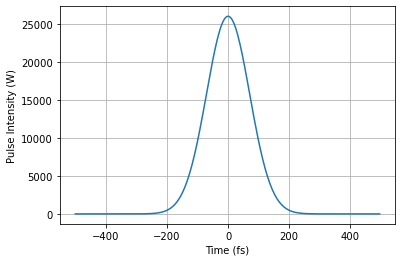

In [13]:
nlo.plot_magsq(t*1e15, pulse)